<a href="https://colab.research.google.com/github/linh0941664362/bank-term-deposit-prediction/blob/main/bank_term_deposit_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PHẦN 1: THIẾT LẬP MÔI TRƯỜNG


In [ ]:
# 1.1. Cài thư viện cần thiết nếu dùng Google Colab
# !pip install imbalanced-learn shap lime openpyxl --quiet

# 1.2. Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

import warnings
warnings.filterwarnings('ignore')

# Xử lý dữ liệu
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

# Mô hình
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.dummy import DummyClassifier

# Đánh giá
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

# Xử lý mất cân bằng
from imblearn.over_sampling import SMOTE

# Explainable AI
import shap

# Lưu trữ
import joblib


# PHẦN 2: KHÁM PHÁ DỮ LIỆU (eda)
y - has the client subscribed a term deposit? (binary: 'yes', 'no')

In [ ]:
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
df = pd.read_excel(file_path)

Saving bank-additional-full.xlsx to bank-additional-full.xlsx


In [ ]:
print("=== TỔNG QUAN DỮ LIỆU ===")
print(f"Kích thước dataset: {df.shape}")
print("\nKiểu dữ liệu:")
print(df.dtypes)
# Phân bố biến mục tiêu ban đầu
print("\nPhân bố biến mục tiêu:")
print(df['y'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

# Thay 'y' thành số để phân tích
df['y'] = df['y'].map({'yes': 1, 'no': 0})


=== TỔNG QUAN DỮ LIỆU ===
Kích thước dataset: (41188, 21)

Kiểu dữ liệu:
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Phân bố biến mục tiêu:
y
no     88.7%
yes    11.3%
Name: proportion, dtype: object


In [ ]:
# 2.1 Phân tích missing data & giá trị đặc biệt
print("\n=== GIÁ TRỊ KHÔNG HỢP LỆ ===")
print("Giá trị 'unknown' trong các biến phân loại:")
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    unknown_pct = (df[col] == 'unknown').mean() * 100
    print(f"{col}: {unknown_pct:.1f}%")

print("\nGiá trị đặc biệt trong biến số:")
print(f"pdays=999 (chưa từng liên hệ): {(df['pdays'] == 999).mean():.1%}")
print(f"duration=0 (thời lượng 0): {(df['duration'] == 0).mean():.1%}")



=== GIÁ TRỊ KHÔNG HỢP LỆ ===
Giá trị 'unknown' trong các biến phân loại:
job: 0.8%
marital: 0.2%
education: 4.2%
default: 20.9%
housing: 2.4%
loan: 2.4%

Giá trị đặc biệt trong biến số:
pdays=999 (chưa từng liên hệ): 96.3%
duration=0 (thời lượng 0): 0.0%


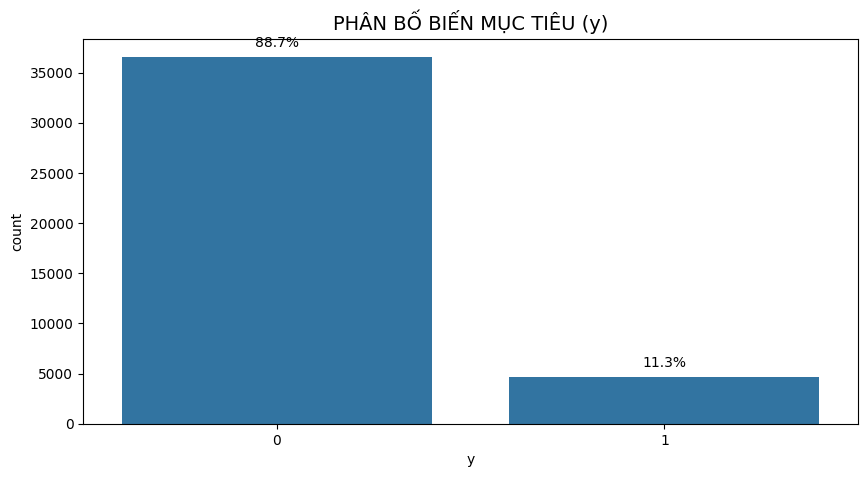

In [ ]:
# 2.2 Biểu đồ phân bố biến mục tiêu
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='y', data=df)
plt.title('PHÂN BỐ BIẾN MỤC TIÊU (y)', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{p.get_height()/len(df):.1%}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')
plt.show()



=== PHÂN TÍCH NHÂN KHẨU HỌC ===


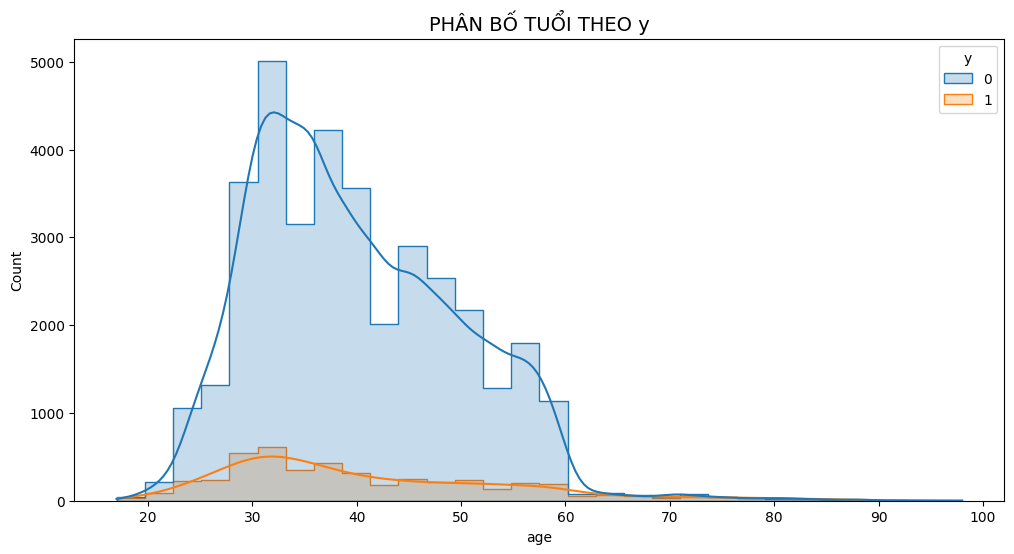

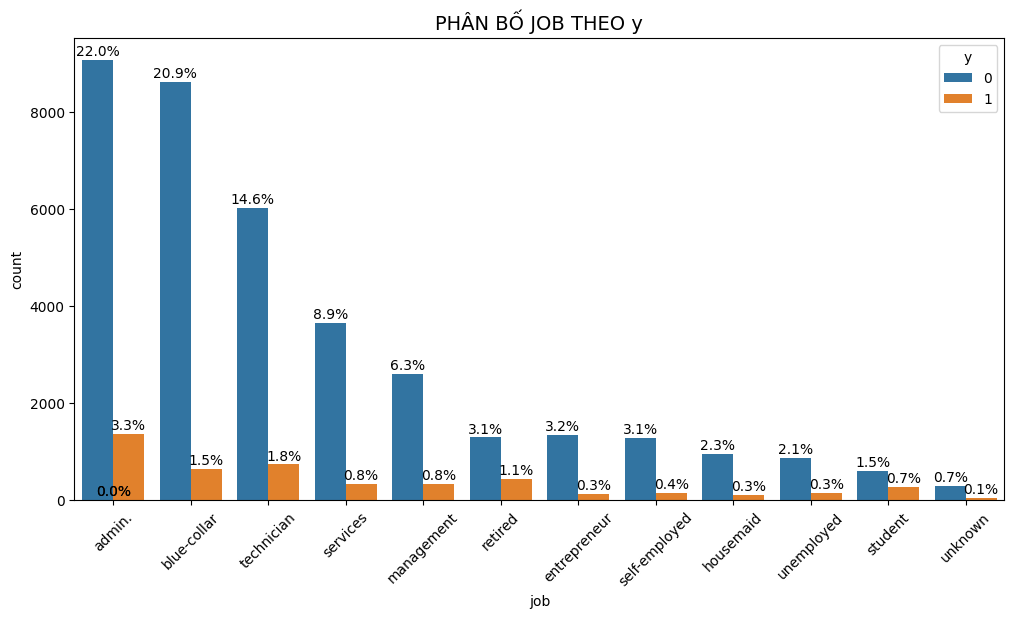

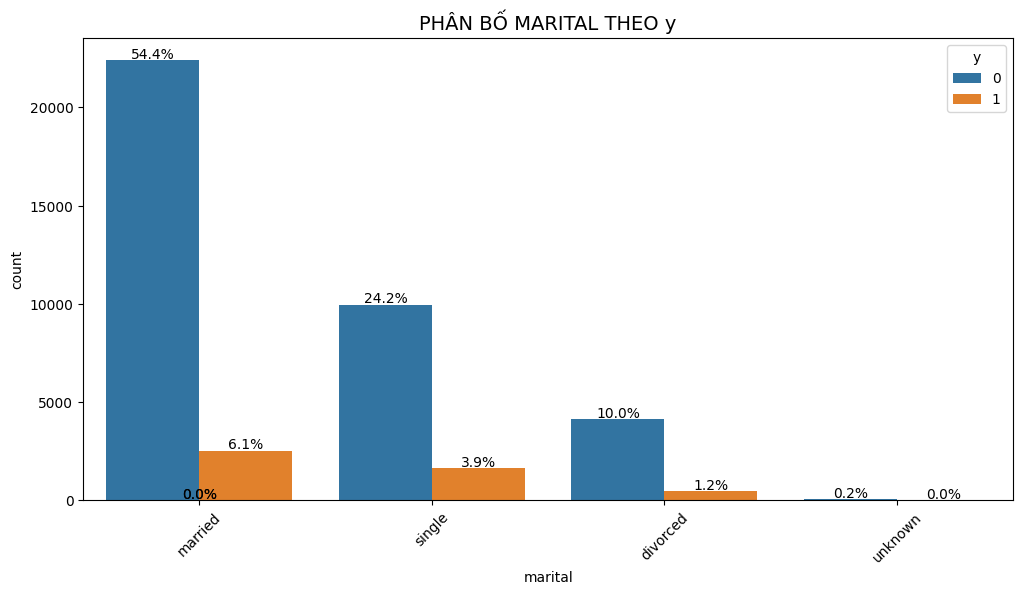

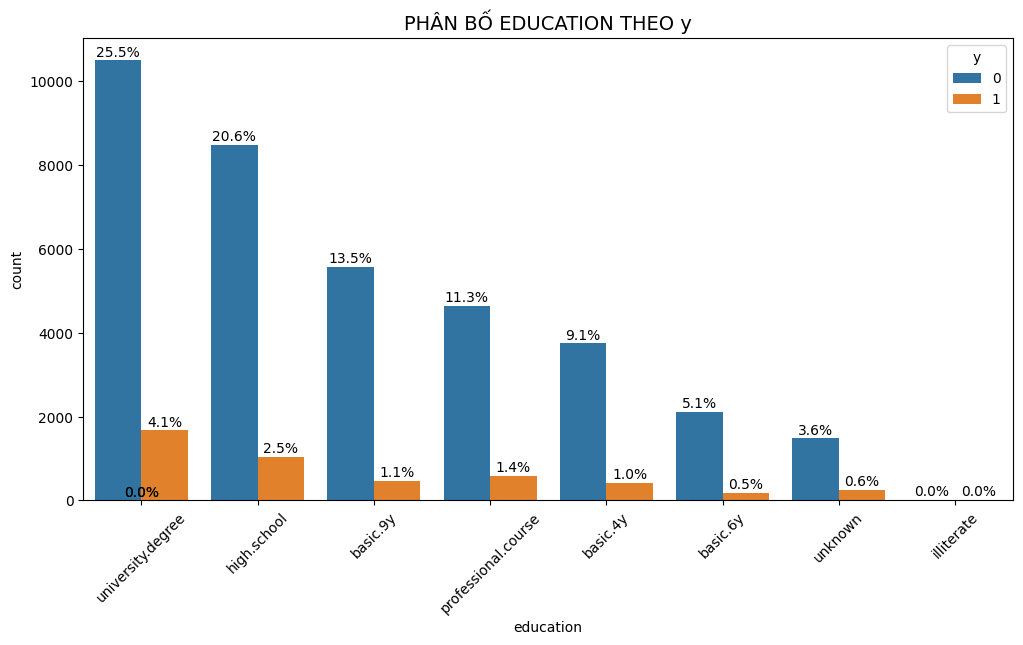

In [ ]:
# 2.3 Phân tích nhân khẩu học
print("\n=== PHÂN TÍCH NHÂN KHẨU HỌC ===")

# Tuổi
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', hue='y', bins=30, kde=True, element='step')
plt.title('PHÂN BỐ TUỔI THEO y', fontsize=14)
plt.show()

# Các biến phân loại
for col in ['job', 'marital', 'education']:
    plt.figure(figsize=(12, 6))
    order = df[col].value_counts().index
    ax = sns.countplot(x=col, hue='y', data=df, order=order)
    plt.title(f'PHÂN BỐ {col.upper()} THEO y', fontsize=14)
    plt.xticks(rotation=45)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 100, f'{height/len(df):.1%}', ha='center')
    plt.show()


=== PHÂN TÍCH CÁC CUỘC GỌI ===


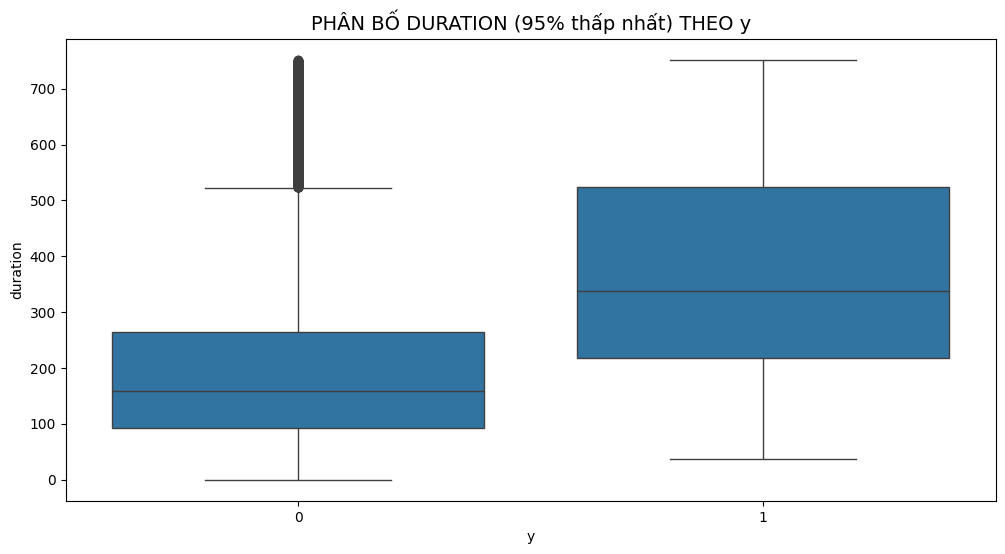

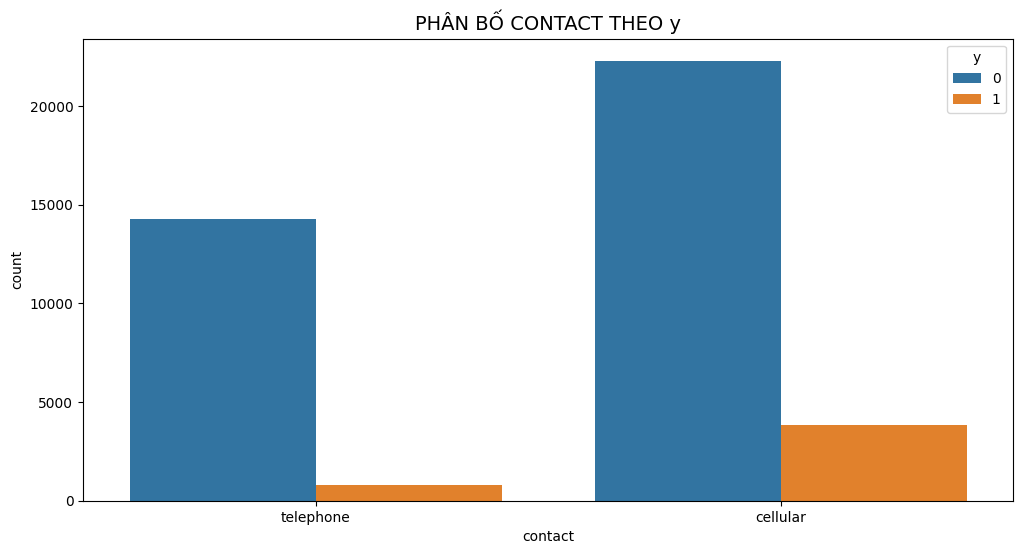

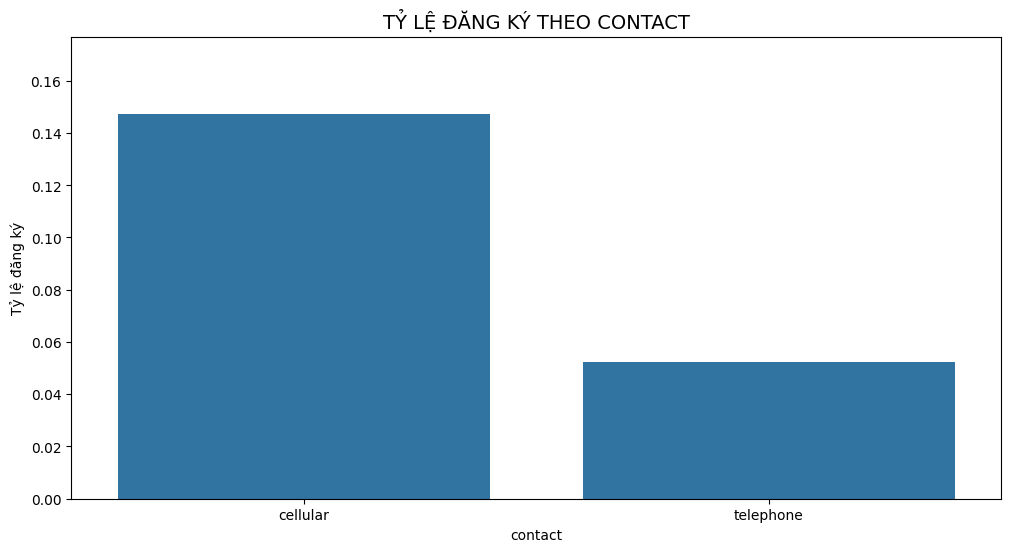

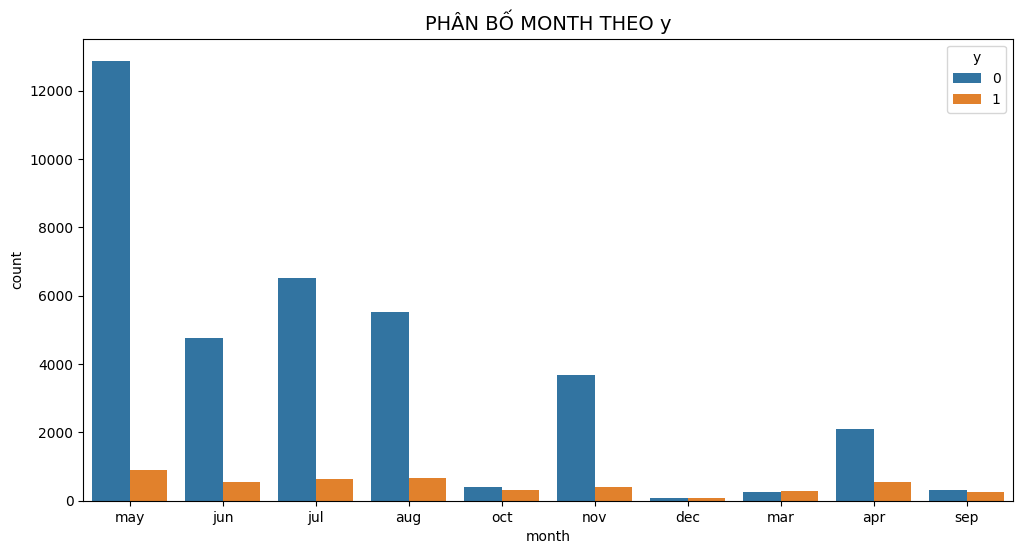

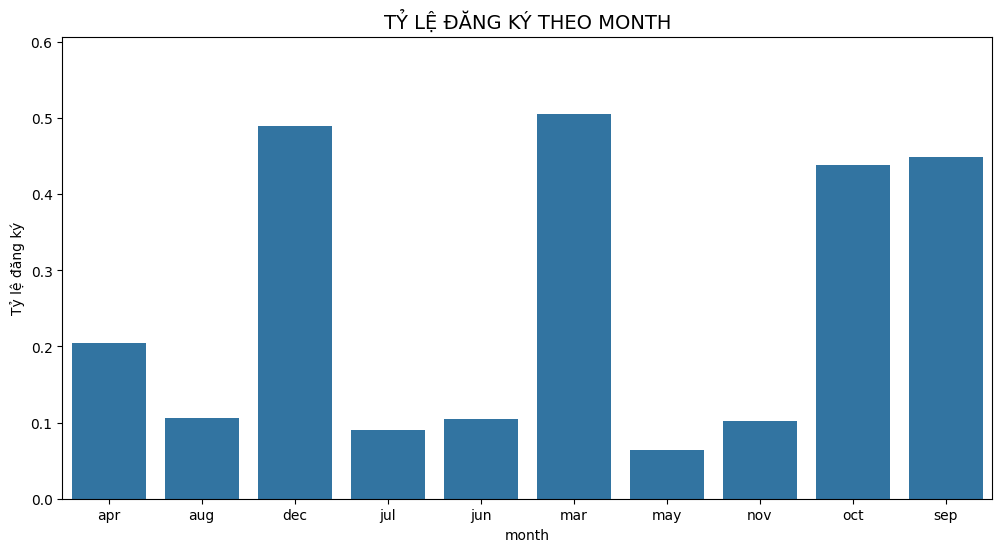

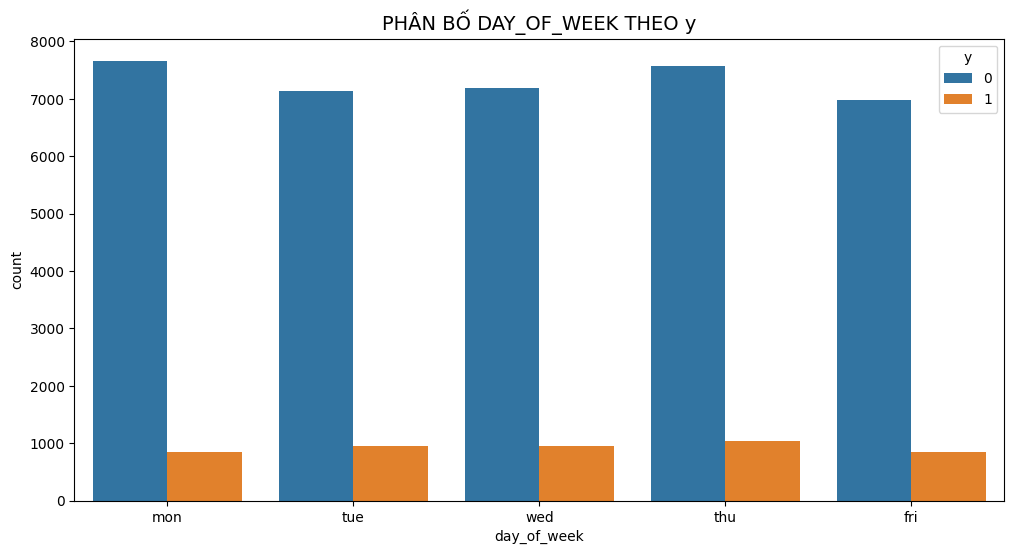

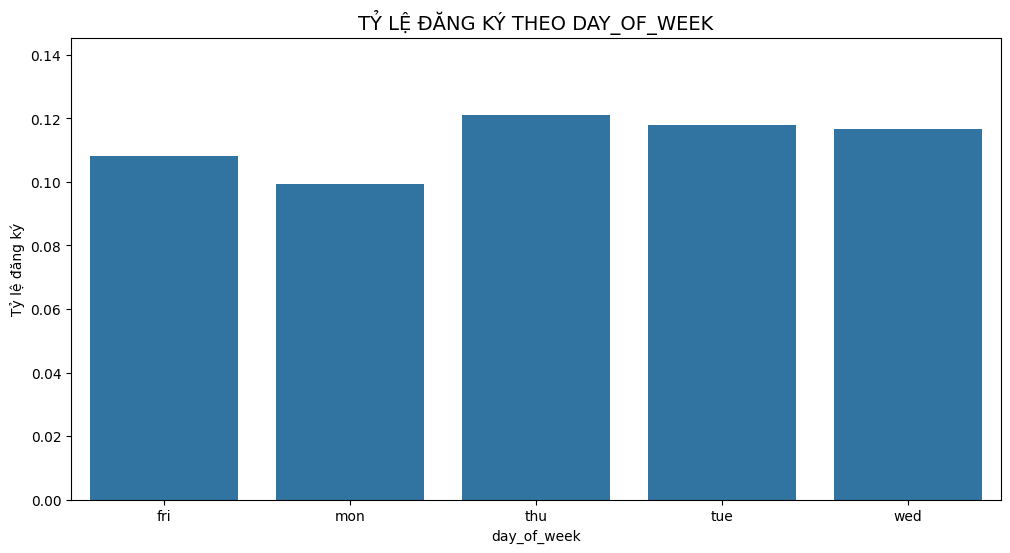

In [ ]:
# 2.4 Phân tích cuộc gọi
print("\n=== PHÂN TÍCH CÁC CUỘC GỌI ===")

# Duration (loại bỏ outlier 5%)
plt.figure(figsize=(12, 6))
sns.boxplot(x='y', y='duration', data=df[df['duration'] <= df['duration'].quantile(0.95)])
plt.title('PHÂN BỐ DURATION (95% thấp nhất) THEO y', fontsize=14)
plt.show()

# Các biến thời điểm
for col in ['contact', 'month', 'day_of_week']:
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(x=col, hue='y', data=df)
    plt.title(f'PHÂN BỐ {col.upper()} THEO y', fontsize=14)
    plt.show()

    # Tỷ lệ chuyển đổi theo biến đó
    conversion = df.groupby(col)['y'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=col, y='y', data=conversion)
    plt.title(f'TỶ LỆ ĐĂNG KÝ THEO {col.upper()}', fontsize=14)
    plt.ylabel('Tỷ lệ đăng ký')
    plt.ylim(0, conversion['y'].max()*1.2)
    plt.show()


=== LỊCH SỬ CHIẾN DỊCH ===


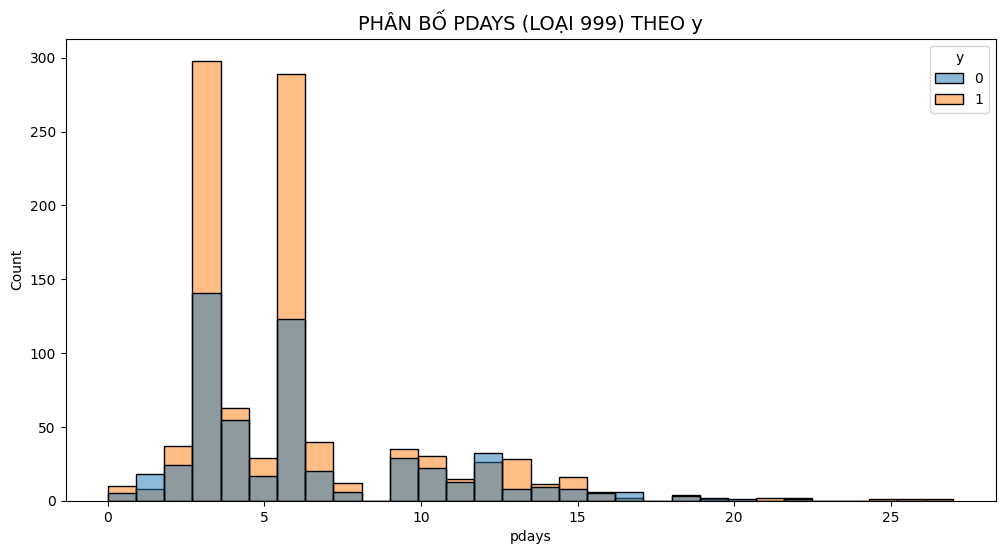

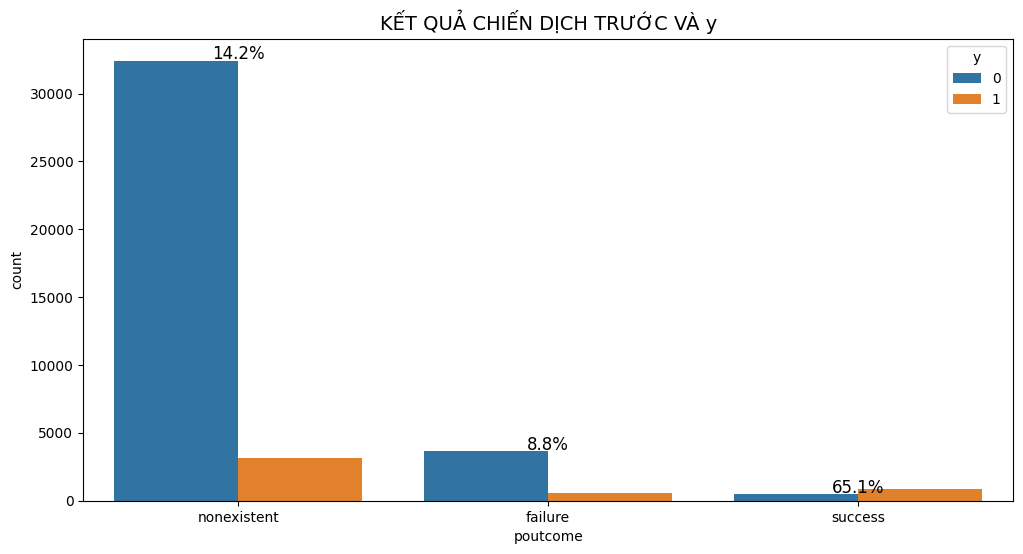

In [ ]:
# 2.5 Lịch sử chiến dịch
print("\n=== LỊCH SỬ CHIẾN DỊCH ===")

# Pdays
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['pdays'] < 999], x='pdays', hue='y', bins=30)
plt.title('PHÂN BỐ PDAYS (LOẠI 999) THEO y', fontsize=14)
plt.show()

# Poutcome
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='poutcome', hue='y', data=df)
plt.title('KẾT QUẢ CHIẾN DỊCH TRƯỚC VÀ y', fontsize=14)
conversion = df.groupby('poutcome')['y'].mean()
for i, (k, v) in enumerate(conversion.items()):
    ax.text(i, ax.patches[i].get_height() + 100, f'{v:.1%}', ha='center', fontsize=12)
plt.show()


=== CHỈ SỐ KINH TẾ ===


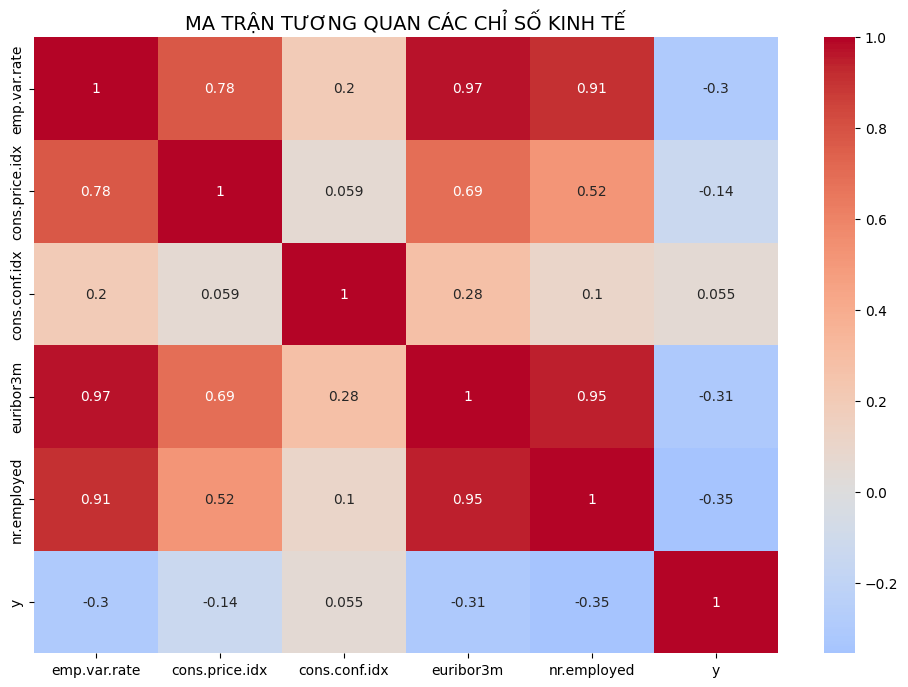

In [ ]:
# 2.6 Các chỉ số kinh tế
print("\n=== CHỈ SỐ KINH TẾ ===")
economic_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
plt.figure(figsize=(12, 8))
sns.heatmap(df[economic_cols + ['y']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('MA TRẬN TƯƠNG QUAN CÁC CHỈ SỐ KINH TẾ', fontsize=14)
plt.show()


# PHẦN 3: TIỀN XỬ LÝ DỮ LIỆU

In [ ]:
# 3.1. Gán lại biến target và loại bỏ duration
df_processed = df.copy()
df_processed.drop(columns=['duration'], inplace=True)
unknown_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# 3.2. Thay unknown bằng NaN
df_processed[unknown_cols] = df_processed[unknown_cols].replace('unknown', np.nan)

# THÊM: Tạo biến 'age_group' từ 'age'
# Phân loại tuổi thành các nhóm
bins = [0, 18, 25, 35, 50, 65, 100]
labels = ['<18', '18-25', '26-35', '36-50', '51-65', '65+']
df_processed['age_group'] = pd.cut(df_processed['age'], bins=bins, labels=labels, right=False)
# Xử lý các giá trị NaN có thể xuất hiện nếu age nằm ngoài bins (mặc dù bins đã bao phủ rộng)
df_processed['age_group'] = df_processed['age_group'].astype(str).replace('nan', labels[0]) # Gán '<18' cho các trường hợp nằm ngoài range nếu có

# 3.3. Tách X và y
X = df_processed.drop(columns=['y'])
y = df_processed['y']

# 3.4. Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3.5. Xác định các loại biến
# 'age_group' đã được thêm vào df_processed và X/X_train
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week', 'poutcome', 'age_group']
num_cols = ['age', 'campaign', 'pdays', 'previous']
special_num_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
# Binary variable 'prev_contacted' is not created in the current code.
# If you intend to create it later, ensure it's added to the DataFrame
# before this step. For now, keeping it commented out or removed if not used.
# binary_cols = ['prev_contacted']
binary_cols = [] # Assuming 'prev_contacted' is not used based on the provided code

# 3.6. Tạo các transformer
numeric_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    # SimpleImputer will handle potential NaNs in 'age_group' created by pd.cut if not handled above
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

special_num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# 3.7. ColumnTransformer
# Ensure binary_cols is correctly handled based on if it's used
if binary_cols:
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('special', special_num_transformer, special_num_cols),
        ('binary', 'passthrough', binary_cols)
    ])
else: # If no binary columns are specified
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('special', special_num_transformer, special_num_cols)
    ])

# 3.8. Pipeline tổng
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_classif, k='all')) # k='all' keeps all features
])

# 3.9. Fit-transform và xử lý SMOTE
X_train_processed = full_pipeline.fit_transform(X_train, y_train)
X_test_processed = full_pipeline.transform(X_test)

smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# 3.10. Lưu pipeline
joblib.dump(full_pipeline, 'pipeline.pkl')
joblib.dump((X_train_resampled, y_train_resampled, X_test_processed, y_test), 'processed_data.pkl')

['processed_data.pkl']

# PHẦN 4: MÔ HÌNH & ĐÁNH GIÁ

In [ ]:
X_train_resampled, y_train_resampled, X_test_processed, y_test = joblib.load('processed_data.pkl')

models = {
    'Dummy': DummyClassifier(strategy='most_frequent', random_state=42),
    'Logistic': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'Logistic': {'C': [0.01, 0.1, 1, 10]},
    'DecisionTree': {'max_depth': [3, 5, 10]},
    'RandomForest': {'n_estimators': [100, 200]},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

results = []
best_estimators = {}

for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    if name in param_grids:
        clf = GridSearchCV(model, param_grids[name], scoring='roc_auc', cv=cv, n_jobs=-1)
    else:
        clf = model

    clf.fit(X_train_resampled, y_train_resampled)
    best_model = clf.best_estimator_ if hasattr(clf, 'best_estimator_') else clf
    best_estimators[name] = best_model

    y_pred = best_model.predict(X_test_processed)
    y_proba = best_model.predict_proba(X_test_processed)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    print(classification_report(y_test, y_pred))
    print(f"AUC = {auc:.4f}")

    results.append({
        'Model': name,
        'AUC': auc,
        'BestParams': clf.best_params_ if hasattr(clf, 'best_params_') else 'N/A'
    })
# === Bảng tổng hợp kết quả
summary = []

for name, model in best_estimators.items():
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    summary.append({
        'Model': name,
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

# Hiển thị bảng
summary_df = pd.DataFrame(summary).sort_values('AUC', ascending=False)
print("\n📊 BẢNG TỔNG HỢP KẾT QUẢ MÔ HÌNH")
print(summary_df.to_string(index=False))

print("\n📋 ĐÁNH GIÁ CHI TIẾT MÔ HÌNH:")
for name, model in best_estimators.items():
    y_pred = model.predict(X_test_processed)
    print(f"\n🔹 {name}")
    print(classification_report(y_test, y_pred, digits=4))



🔍 Training Dummy...
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7310
           1       0.00      0.00      0.00       928

    accuracy                           0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.79      0.89      0.83      8238

AUC = 0.5000

🔍 Training Logistic...
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7310
           1       0.35      0.65      0.46       928

    accuracy                           0.83      8238
   macro avg       0.65      0.75      0.68      8238
weighted avg       0.88      0.83      0.85      8238

AUC = 0.8002

🔍 Training DecisionTree...
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7310
           1       0.45      0.51      0.48       928

    accuracy                           0.87      8238
   macro avg       0.69      

# PHẦN 5: ENSEMBLE MODEL

In [ ]:
ensemble = VotingClassifier(
    estimators=[(k, v) for k, v in best_estimators.items() if k != 'Dummy'],
    voting='soft', n_jobs=-1
)
ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_ens = ensemble.predict(X_test_processed)
y_proba_ens = ensemble.predict_proba(X_test_processed)[:, 1]
auc_ens = roc_auc_score(y_test, y_proba_ens)

print("\n[ENSEMBLE MODEL] Classification Report:")
print(classification_report(y_test, y_pred_ens))
print(f"Ensemble AUC: {auc_ens:.4f}")


[ENSEMBLE MODEL] Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7310
           1       0.51      0.51      0.51       928

    accuracy                           0.89      8238
   macro avg       0.73      0.73      0.73      8238
weighted avg       0.89      0.89      0.89      8238

Ensemble AUC: 0.8059


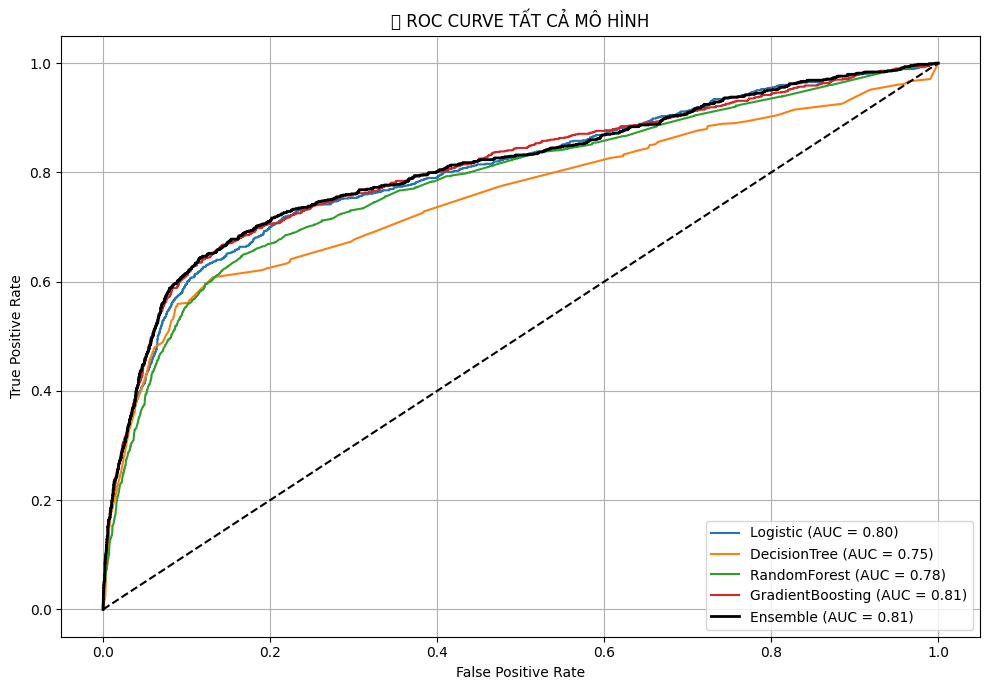

In [ ]:
# Vẽ ROC Curve cho các mô hình
plt.figure(figsize=(10, 7))

# ROC từng model
for name, model in best_estimators.items():
    # Skip plotting ROC for the Dummy model as it's not informative for AUC
    if name == 'Dummy':
        continue

    y_proba = model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    # Use a different variable name for the calculated AUC to avoid conflict
    current_model_auc = roc_auc_score(y_test, y_proba) # Renamed variable
    plt.plot(fpr, tpr, label=f'{name} (AUC = {current_model_auc:.2f})')

# ROC ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_proba_ens)
# Use a different variable name for the calculated AUC
ensemble_auc_score = roc_auc_score(y_test, y_proba_ens) # Renamed variable
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {ensemble_auc_score:.2f})', linewidth=2, color='black')


# Đường chéo
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🌟 ROC CURVE TẤT CẢ MÔ HÌNH')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# PHẦN 6: EXPLAINABLE AI (XAI)

PermutationExplainer explainer: 8239it [2:20:45,  1.03s/it]


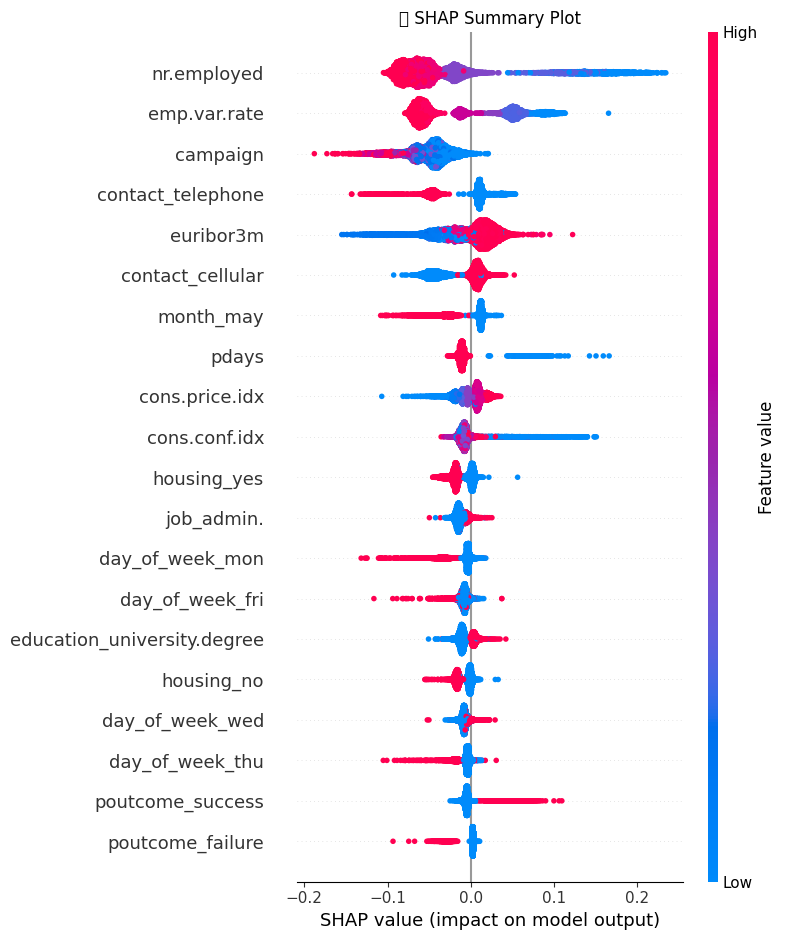

In [ ]:
# Lấy feature names từ transformer
ohe_features = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, ohe_features, special_num_cols, binary_cols])

# SHAP explainer
explainer = shap.Explainer(
    model=ensemble.predict_proba, # Pass the prediction probability function
    masker=shap.maskers.Independent(X_train_resampled), # Use Independent masker with training data
    feature_names=all_features, # Provide feature names
    output_names=['No', 'Yes'] # Provide output names for clarity
)
shap_values = explainer(X_test_processed)

# SHAP summary plot
shap.summary_plot(shap_values[:, :, 1], features=X_test_processed, feature_names=all_features, show=False)
plt.title("🔍 SHAP Summary Plot")
plt.tight_layout()
plt.show()

# PHẦN 7: VIZ & MA TRẬN NHẦM LẪN

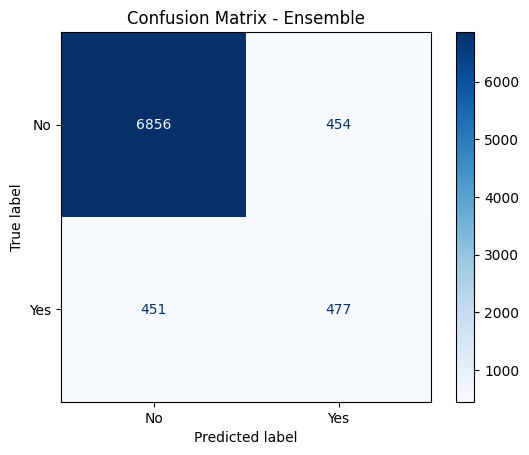

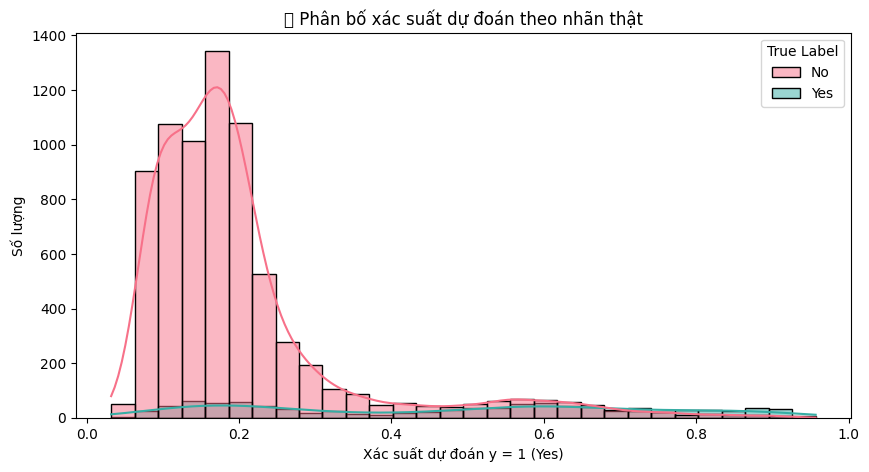

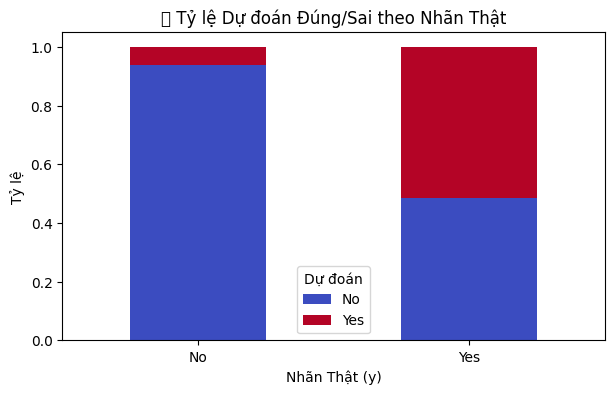

In [ ]:
cm = confusion_matrix(y_test, y_pred_ens)
ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes']).plot(cmap='Blues')
plt.title("Confusion Matrix - Ensemble")
plt.show()

# 7.1. Tạo DataFrame kết quả
results_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred_ens,
    'Predicted Prob': y_proba_ens
}).reset_index(drop=True)

# Chuyển đổi nhãn từ số sang chuỗi cho trực quan
results_df['True Label'] = results_df['True Label'].map({0: 'No', 1: 'Yes'})
results_df['Predicted Label'] = results_df['Predicted Label'].map({0: 'No', 1: 'Yes'})

# 7.2. Phân phối xác suất dự đoán
plt.figure(figsize=(10, 5))
sns.histplot(data=results_df, x='Predicted Prob', hue='True Label', bins=30, kde=True, palette='husl')
plt.title('🔍 Phân bố xác suất dự đoán theo nhãn thật')
plt.xlabel('Xác suất dự đoán y = 1 (Yes)')
plt.ylabel('Số lượng')
plt.show()

# 7.3. Biểu đồ stacked crosstab
ct = pd.crosstab(results_df['True Label'], results_df['Predicted Label'], normalize='index')
ct.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(7, 4))
plt.title('📊 Tỷ lệ Dự đoán Đúng/Sai theo Nhãn Thật Và Nhãn Dự Đoán')
plt.xlabel('Nhãn Thật (y)')
plt.ylabel('Tỷ lệ')
plt.xticks(rotation=0)
plt.legend(title='Dự đoán')
plt.show()
